# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

#### Cluster different neighborhoods in NYC based on available restaurant categories

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a id="introduction"></a>

In this project we will try to cluster different neighborhoods in NYC based on available restaurant categories. As NY has a very diverse cuisine restaurants all around the city it is hard to group areas based on available restaurant types.

Here we will fetch information about restaurants surrounding each neighborhood in the city and create a model which can tell us in which neighborhoods a particular type of restaurant is msost available and which one is least available.

It can help both who is looking for places where a particular type of restaurant is available and also some one who is looking for places where a particular type of restaurant is not available thus that type of restaurant can be opened in that area to run a business. 

<i>let's import all the required libaries required for our data analysis</i>

In [8]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data <a id="data"></a>

To solve the above problem we are going to use data from mainly two sourses - 

**1. NYC neiborhood dataset with locations(latitude and longitude)**

**2. Foursquare 'Places API' will be used to get the data related to venues arround each neighborhood. Our main focus will be on finding restaurants.**

   We need to open the json file and read all the **NYC** neighborhoods data in pandas data frame

In [13]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [14]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


A dataset of food related venues will be created by sending request to the venues endpoint with category id **'4d4b7105d754a06374d81259'** which is going to retutn venues related to food.

In [15]:
#Define foursquare credentails
CLIENT_ID = '2UPPWGMV2XQJBPO1MU0YZGTKOMGDK4CWNVNO3JAISKPVMTL4' # your Foursquare ID
CLIENT_SECRET = '4B2XALJPUYB552TAOKFNFAPR4SVLXUEFMU3FX243J4UARK0M' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [16]:
#function to create url
def createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit):
    url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            endpoint,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            categoryId,
            limit
    )
    return url

#function to return food venues for each neighborhood
def getNearByFoodPlaces(neighborhoods, latitudes, longitudes, radius = 500):
    endpoint = 'https://api.foursquare.com/v2/venues/explore?'
    venues_list = []
    
    for hood, lat, lng in zip(neighborhoods, latitudes, longitudes):
        url = createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        #print(results)
        #results = results['response']['groups'][0]['items']['venue']
        
        for item in results:
            venue_name = item['venue']['name']
            venue_category = item['venue']['categories'][0]['name']
            venue_lat = item['venue']['location']['lat']
            venue_lng = item['venue']['location']['lng']
            try:
                venue_city = item['venue']['location']['city']
            except:
                venue_city = 'N/A'
            venue_state = item['venue']['location']['state']
            
            venues_list.append([(hood,
                                lat,
                                lng,
                                venue_name,
                                venue_category,
                                venue_lat,
                                venue_lng,
                                venue_city,
                                venue_state
                                )])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood_Latitude', 'Neighborhood_Longitude', 'Venue_Name','Venue_Category',
                            'Venue_Latitude', 'Venue_Longitude', 'Venue_city', 'Venue_State']
    return nearby_venues

In [17]:
categoryId = '4d4b7105d754a06374d81259'
limit = 50
venue_data = getNearByFoodPlaces(neighborhoods['Neighborhood'], neighborhoods['Latitude'], neighborhoods['Longitude'])
venue_data.head()

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Name,Venue_Category,Venue_Latitude,Venue_Longitude,Venue_city,Venue_State
0,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,40.898276,-73.850381,Bronx,NY
1,Wakefield,40.894705,-73.847201,Dunkin',Donut Shop,40.890459,-73.849089,Bronx,NY
2,Wakefield,40.894705,-73.847201,SUBWAY,Sandwich Place,40.890656,-73.849192,Bronx,NY
3,Wakefield,40.894705,-73.847201,Pitman Deli,Food,40.894149,-73.845748,Bronx,NY
4,Wakefield,40.894705,-73.847201,Baychester Avenue Food Truck,Food Truck,40.892293,-73.843230,Bronx,NY


In [18]:
venue_data.shape

(6818, 9)

The primary DataFrame has **6818** records

## Methodology <a name="methodology"></a>

In this project we are going to find available restaurants around each neighborhood and based on their category we are going to cluster the neighborhoods. 

We have already collected data of the food places around each neighborhood.

Next we are going to analyze this data to find top five types of restaurants based on their count in each neighborhood.

Later from the cluster analysis we will get an idea about different places and with a particular type of restaurant which is msost available and also least available

## Analysis <a name="analysis"></a>

### Exploratory Data Analysis

Let's find out which are the venue states are pulled from the API request. Later we need to remove entries which are not in **NY** or **New York**

In [19]:
venue_data.groupby('Venue_State')['Venue_State'].count()

Venue_State
NJ             1
NY          6753
New York      64
Name: Venue_State, dtype: int64

Count the number of venue categories returned and while data cleaning places wihch are not related to restaurants will be removed

In [22]:
num_unique = len(venue_data['Venue_Category'].unique())
print("Numbers of venue categories {}".format(num_unique))
venue_data['Venue_Category'].value_counts().sort_values(ascending=False)

Names of venue categories 132


Pizza Place                        647
Deli / Bodega                      599
Chinese Restaurant                 430
Italian Restaurant                 386
Bakery                             294
Mexican Restaurant                 252
Café                               231
Sandwich Place                     226
American Restaurant                218
Donut Shop                         192
Fast Food Restaurant               152
Bagel Shop                         145
Sushi Restaurant                   143
Restaurant                         136
Diner                              122
Food Truck                         118
Japanese Restaurant                115
Fried Chicken Joint                115
Food                               114
Latin American Restaurant          111
Thai Restaurant                    109
Spanish Restaurant                 104
Caribbean Restaurant               101
Seafood Restaurant                 101
Korean Restaurant                  100
Burger Joint             

ChecK for the records for which the city name parameter is not filled.

In [23]:
num_unknown_cities = venue_data[venue_data['Venue_city'] == 'N/A']['Venue_Name'].count()
print('For {} venues city names are unknown'.format(num_unknown_cities))

For 64 venues city names are unknown


Find out is there any null value in the DataFrame

In [24]:
venue_data.isnull().values.any()

False

There were no null values found in the DataFrame

### Data Cleaning

Records for which venue states are not related to **NY** and **New York** will be dropped and all the NYs will be replaced with New York

In [25]:
ny_data = venue_data[(venue_data['Venue_State'] == 'New York') | (venue_data['Venue_State'] == 'NY')]
ny_data['Venue_State'].replace(to_replace='New York', value='NY', inplace=True)
delta = venue_data.shape[0] - ny_data.shape[0]
print("{} Entries were removed".format(delta))
ny_data.head()

1 Entries were removed


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Name,Venue_Category,Venue_Latitude,Venue_Longitude,Venue_city,Venue_State
0,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,40.898276,-73.850381,Bronx,NY
1,Wakefield,40.894705,-73.847201,Dunkin',Donut Shop,40.890459,-73.849089,Bronx,NY
2,Wakefield,40.894705,-73.847201,SUBWAY,Sandwich Place,40.890656,-73.849192,Bronx,NY
3,Wakefield,40.894705,-73.847201,Pitman Deli,Food,40.894149,-73.845748,Bronx,NY
4,Wakefield,40.894705,-73.847201,Baychester Avenue Food Truck,Food Truck,40.892293,-73.843230,Bronx,NY


Remove the entries with city name **N/A**

In [27]:
ny_data_city = ny_data[ny_data['Venue_city'] != 'N/A']
delta = ny_data.shape[0] - ny_data_city.shape[0]
print("{} Entries were removed".format(delta))
ny_data_city.head()

64 Entries were removed


,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Name,Venue_Category,Venue_Latitude,Venue_Longitude,Venue_city,Venue_State
0,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,40.898276,-73.850381,Bronx,NY
1,Wakefield,40.894705,-73.847201,Dunkin',Donut Shop,40.890459,-73.849089,Bronx,NY
2,Wakefield,40.894705,-73.847201,SUBWAY,Sandwich Place,40.890656,-73.849192,Bronx,NY
3,Wakefield,40.894705,-73.847201,Pitman Deli,Food,40.894149,-73.845748,Bronx,NY
4,Wakefield,40.894705,-73.847201,Baychester Avenue Food Truck,Food Truck,40.892293,-73.843230,Bronx,NY


Now we are going to define a list of restaurant types on which we are going to concentrate in this analysis

In [28]:
restaurant_categories = ['Chinese Restaurant', 'Italian Restaurant', 'Mexican Restaurant', 'American Restaurant', 
                         'Fast Food Restaurant', 'Sushi Restaurant', 'Japanese Restaurant', 'Latin American Restaurant', 
                         'Thai Restaurant', 'Spanish Restaurant', 'Caribbean Restaurant', 'Seafood Restaurant', 
                         'Korean Restaurant', 'Indian Restaurant', 'French Restaurant']

Let's filter our data based on the defined restaurant categories

In [29]:
ny_restaurants = ny_data_city[ny_data_city['Venue_Category'].isin(restaurant_categories)]
delta = ny_data_city.shape[0] - ny_restaurants.shape[0]
print("{} Entries were removed".format(delta))
ny_restaurants.head()

4254 Entries were removed


,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Name,Venue_Category,Venue_Latitude,Venue_Longitude,Venue_city,Venue_State
0,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,40.898276,-73.850381,Bronx,NY
7,Co-op City,40.874294,-73.829939,Arby's,Fast Food Restaurant,40.870518,-73.828657,Bronx,NY
10,Co-op City,40.874294,-73.829939,Guang Hui Chinese Restaurant,Chinese Restaurant,40.876603,-73.829710,Bronx,NY
12,Co-op City,40.874294,-73.829939,Kennedy's,Fast Food Restaurant,40.876807,-73.829627,Bronx,NY
16,Eastchester,40.887556,-73.827806,Fish & Ting,Caribbean Restaurant,40.885539,-73.829151,Bronx,NY


### One-Hot-Encoding venue categories

To use Foursquare’s category values to find similar neighborhoods based on restaurant types, a one-hot-encoding 
representation of each entry was created using Pandas’ ‘get_dummies’ function. The result was a dataframe of New York City 
rastaurant related venues where entry venue category is represented by a value of 1 in the column of matching venue category.

In [30]:
ny_venue_onehot = pd.get_dummies(ny_restaurants[['Venue_Category']], prefix='', prefix_sep='')
ny_venue_onehot['Neighborhood'] = ny_restaurants['Neighborhood']
fixed_columns = [ny_venue_onehot.columns[-1]] + list(ny_venue_onehot.columns[:-1])
ny_venue_onehot = ny_venue_onehot[fixed_columns]
ny_venue_onehot.head(20)

,Neighborhood,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant
0,Wakefield,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Co-op City,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10,Co-op City,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12,Co-op City,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
16,Eastchester,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Eastchester,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
22,Eastchester,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
23,Eastchester,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
25,Eastchester,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
26,Eastchester,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### Data Visualization

Counts of the venues were determined for each venue category and neighborhood in New York City using the one hot encoded DataFrame.

Calculate total number of each category in each neighborhood

In [31]:
venue_counts = ny_venue_onehot.groupby('Neighborhood').sum()
venue_counts.head(8)

,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant
Neighborhood,,,,,,,,,,,,,,,
Allerton,1,0,3,1,0,0,0,0,0,0,1,0,1,0,0
Annadale,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Arlington,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
Arverne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Astoria,0,0,0,0,0,2,3,0,1,2,1,4,0,0,1
Astoria Heights,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0
Auburndale,1,0,0,1,0,0,2,0,3,0,0,0,0,0,0


Let's plot bar plots for to visualize top 20 neighborhoods with most of the category available
Here we are going to visualize data for this ('Chinese Restaurant', 'Italian Restaurant', 'Mexican Restaurant', 'American Restaurant', 'Fast Food Restaurant')
list of categories

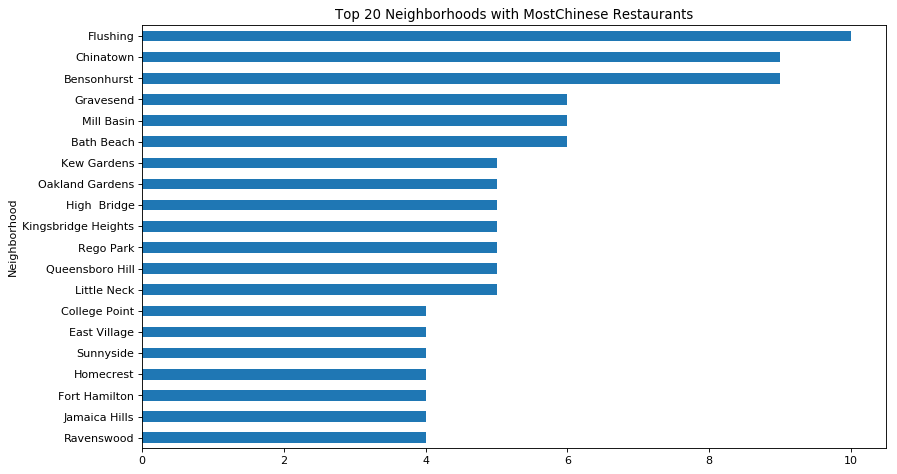

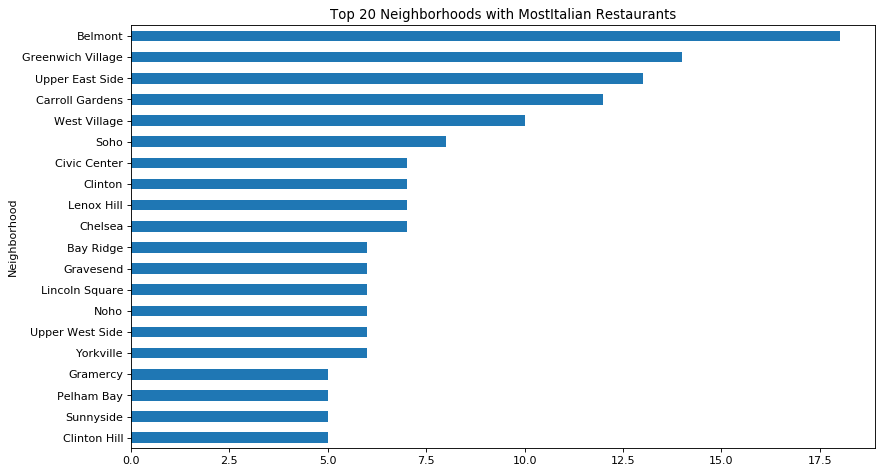

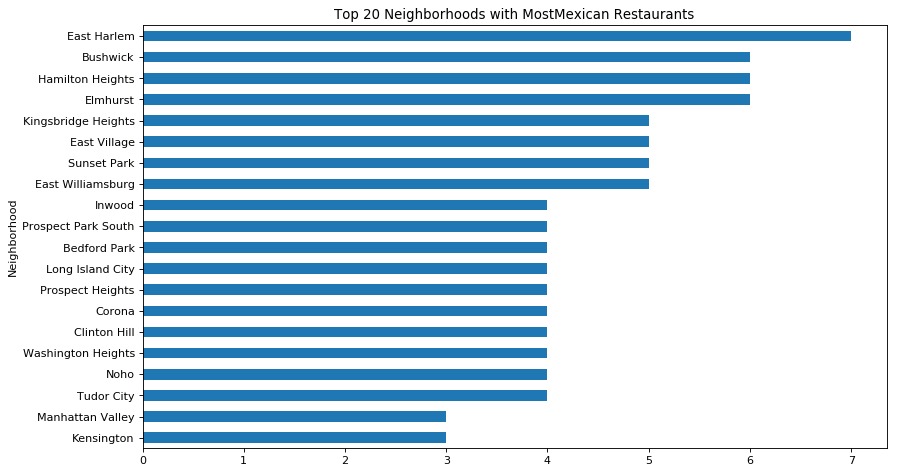

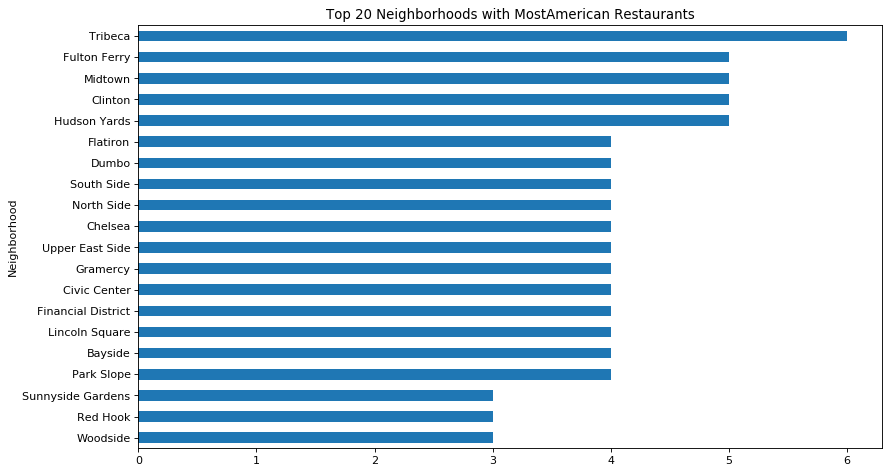

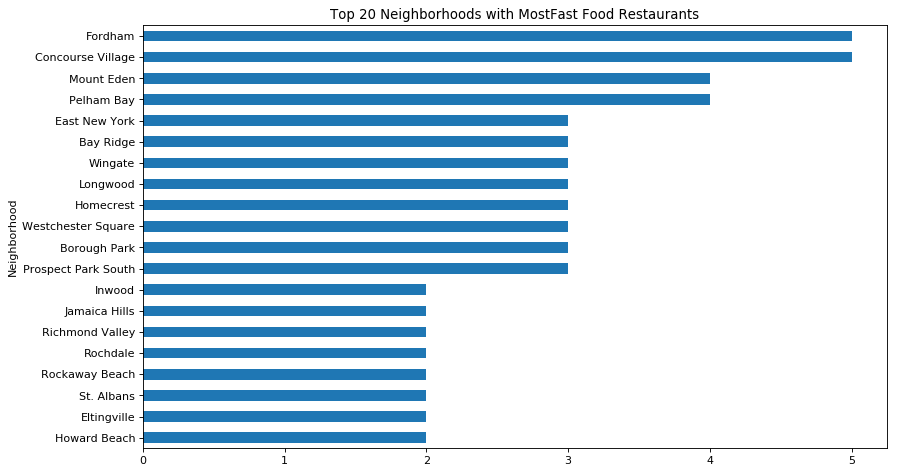

In [34]:
import matplotlib.pyplot as plt
plot_categories = ['Chinese Restaurant', 'Italian Restaurant', 'Mexican Restaurant', 'American Restaurant', 'Fast Food Restaurant']
n = 20
for category in plot_categories:
    plt.figure(num=None, figsize = (12,7), dpi=80, facecolor='w', edgecolor = 'k')
    plt.title(f'Top {n} Neighborhoods with Most{category}s')
    top_category_neighborhoods = venue_counts[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods = top_category_neighborhoods.sort_values(ascending=True)
    top_category_neighborhoods.plot.barh(y=category, rot=0)

### Feature Creation

Using the one-hot encoded dataframe we will calculate the percentage distribution for each categoty

In [35]:
venue_totals = {}
for category in restaurant_categories:
    venue_totals[category] = venue_counts[category].sum()
    
venue_totals

{'Chinese Restaurant': 426,
 'Italian Restaurant': 386,
 'Mexican Restaurant': 251,
 'American Restaurant': 217,
 'Fast Food Restaurant': 151,
 'Sushi Restaurant': 143,
 'Japanese Restaurant': 115,
 'Latin American Restaurant': 111,
 'Thai Restaurant': 109,
 'Spanish Restaurant': 101,
 'Caribbean Restaurant': 101,
 'Seafood Restaurant': 100,
 'Korean Restaurant': 99,
 'Indian Restaurant': 97,
 'French Restaurant': 92}

In [36]:
venue_mean = venue_counts
for category, total in venue_totals.items():
    venue_mean[category] = venue_counts[category].apply(lambda x:x / total)
venue_mean = venue_mean.reindex(sorted(venue_mean.columns), axis=1)
#venue_mean.reset_index(inplace=True)
venue_mean.head()

,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant
Neighborhood,,,,,,,,,,,,,,,
Allerton,0.004608,0.000000,0.007042,0.006623,0.0,0.0,0.000000,0.0,0.0,0.0,0.003984,0.0,0.009901,0.000000,0.000000
Annadale,0.013825,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.006993,0.000000
Arlington,0.009217,0.009901,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
Arrochar,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.005181,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
Arverne,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.009174


Using the above data a DataFrame with **top five** categories for each neiborhoods is created

In [50]:
def return_top_venue_categories(row, num_top_venues):
    
    row_categories = row.iloc[0:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Top Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Top Venue Category'.format(ind+1))
        
neighborhood_top_venue_categories = pd.DataFrame(columns=columns)
neighborhood_top_venue_categories['Neighborhood'] = venue_mean.index

for ind in np.arange(venue_mean.shape[0]):
    neighborhood_top_venue_categories.iloc[ind, 1:] = return_top_venue_categories(venue_mean.iloc[ind, :], num_top_venues)
    
neighborhood_top_venue_categories.head()

,Neighborhood,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,Allerton,Spanish Restaurant,Chinese Restaurant,Fast Food Restaurant,American Restaurant,Mexican Restaurant
1,Annadale,American Restaurant,Sushi Restaurant,Thai Restaurant,Spanish Restaurant,Seafood Restaurant
2,Arlington,Caribbean Restaurant,American Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant
3,Arrochar,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Seafood Restaurant
4,Arverne,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Seafood Restaurant,Mexican Restaurant


Using the above data a DataFrame with **Bottom five** categories for each neiborhoods is created

In [51]:
def return_bottom_venue_categories(row, num_top_venues):   
    row_categories = row.iloc[0:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Bottom Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Bottom Venue Category'.format(ind+1))
        
neighborhood_bottom_venue_categories = pd.DataFrame(columns=columns)
neighborhood_bottom_venue_categories['Neighborhood'] = venue_mean.index

for ind in np.arange(venue_mean.shape[0]):
    neighborhood_bottom_venue_categories.iloc[ind, 1:] = return_bottom_venue_categories(venue_mean.iloc[ind, :], num_top_venues)
    
neighborhood_bottom_venue_categories.head()

,Neighborhood,1st Bottom Venue Category,2nd Bottom Venue Category,3rd Bottom Venue Category,4th Bottom Venue Category,5th Bottom Venue Category
0,Allerton,Caribbean Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant
1,Annadale,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
2,Arlington,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant
3,Arrochar,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant
4,Arverne,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant


## Results and Discussion <a name="results"></a>

## Clustering

Using Scikit learn's K means clustering algorithm we are going to cluster the neighborhoods based on the available retaurant types.
Before feeding the data to fit the model we are going to mormalize the data set using Standard scaler method

In [41]:
#transform the data

scaler = StandardScaler(with_std=True)
print(scaler.fit(venue_mean))
k_clusters = 15
print(scaler.transform(venue_mean).shape)

#create and fit the model
kmeans = KMeans(n_clusters = k_clusters, random_state=0).fit(scaler.transform(venue_mean))

#view the labels
kmeans.labels_

StandardScaler(copy=True, with_mean=True, with_std=True)
(272, 15)


array([13,  1,  1,  1,  1,  4,  1,  1,  9,  5,  5,  1, 13,  4, 13,  1,  1,
        1,  1,  1,  2,  9,  1,  8,  1,  1,  1,  1,  1, 13,  5, 13,  5,  6,
        0,  1, 14, 12, 13,  1,  8,  1,  8,  9, 13, 13,  2,  1,  1,  8, 14,
        1, 12,  6,  1,  7,  5,  0, 13,  1,  1,  7,  0,  1,  5, 12,  8,  1,
        1,  1,  6,  7, 13,  8, 12,  0,  1,  1,  1,  1,  1, 12,  5,  0,  1,
        8,  0, 14,  0,  1,  9,  7,  1,  1, 14,  9,  1,  1,  8,  1,  1,  1,
        1,  5, 12,  1,  1,  9, 13, 14,  2,  1,  6,  1, 13, 13,  1,  1,  5,
        5,  8,  1, 14, 13,  6, 10,  0,  1,  4, 12,  9,  1,  6,  6,  0,  1,
       14,  1,  8,  1, 12,  9,  5,  1, 13,  1,  1,  1,  4,  8,  1,  1,  1,
        1,  9, 13, 13,  1, 14,  3,  1,  9,  8, 13, 13, 13,  7,  7, 13, 11,
        5,  1,  7,  1, 14, 13,  1,  8, 13,  9,  1,  1,  1,  0, 13,  1, 12,
       13,  5, 13,  1,  1,  1, 13,  1,  1, 12,  0,  0, 13,  9,  1,  5,  8,
        9,  0, 13,  1,  1,  5,  1, 13,  1,  1,  1,  1,  1,  1,  0,  1, 13,
        1,  1,  1,  2, 13

Now insert the labels in our top venue categories dataframe

In [43]:
neighborhood_top_venue_categories.insert(1, 'Cluster Labels', kmeans.labels_)
neighborhood_top_venue_categories.head()

,Neighborhood,Cluster Labels,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,Allerton,13,Spanish Restaurant,Chinese Restaurant,Fast Food Restaurant,American Restaurant,Mexican Restaurant
1,Annadale,1,American Restaurant,Sushi Restaurant,Thai Restaurant,Spanish Restaurant,Seafood Restaurant
2,Arlington,1,Caribbean Restaurant,American Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant
3,Arrochar,1,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Seafood Restaurant
4,Arverne,1,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Seafood Restaurant,Mexican Restaurant


Now join this above dataframe with our main NYC neighborhood data frame with location data

In [44]:
ny_neighborhood_restaurants = neighborhoods.drop(columns=['Borough'])
ny_neighborhood_restaurants = ny_neighborhood_restaurants.set_index('Neighborhood').join(neighborhood_top_venue_categories.set_index('Neighborhood'), how='right')

ny_neighborhood_restaurants =  ny_neighborhood_restaurants.reset_index()
ny_neighborhood_restaurants.head(10)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,Allerton,40.865788,-73.859319,13,Spanish Restaurant,Chinese Restaurant,Fast Food Restaurant,American Restaurant,Mexican Restaurant
1,Annadale,40.538114,-74.178549,1,American Restaurant,Sushi Restaurant,Thai Restaurant,Spanish Restaurant,Seafood Restaurant
2,Arlington,40.635325,-74.165104,1,Caribbean Restaurant,American Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant
3,Arrochar,40.596313,-74.067124,1,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Seafood Restaurant
4,Arverne,40.589144,-73.791992,1,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Seafood Restaurant,Mexican Restaurant
5,Astoria,40.768509,-73.915654,4,Seafood Restaurant,Indian Restaurant,Latin American Restaurant,Korean Restaurant,Thai Restaurant
6,Astoria Heights,40.770317,-73.894680,1,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant
7,Auburndale,40.761730,-73.791762,1,Korean Restaurant,Fast Food Restaurant,Italian Restaurant,American Restaurant,Thai Restaurant
8,Bath Beach,40.599519,-73.998752,9,Chinese Restaurant,Sushi Restaurant,Fast Food Restaurant,Indian Restaurant,Spanish Restaurant
9,Battery Park City,40.711932,-74.016869,5,Seafood Restaurant,Sushi Restaurant,Italian Restaurant,Chinese Restaurant,American Restaurant


### Cluster Vizualization

Let's vizualize the clusters on NYC map using folium.

In [45]:
latitude = 40.730610
longitude = -73.935242
map_clusters = folium.Map(location=[latitude, longitude], zoom_start = 10)

x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, hood, cluster in zip(ny_neighborhood_restaurants['Latitude'], ny_neighborhood_restaurants['Longitude'], ny_neighborhood_restaurants['Neighborhood'], ny_neighborhood_restaurants['Cluster Labels']):
    label = folium.Popup(hood + ' Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7
    ).add_to(map_clusters)
    
map_clusters

### Evaluation

From the above visualization we can see the similar neighborhoods based on available restaurant types and their distribution.
Most of the places in **Staten Island** are falling under cluster one. Most of the neighborhoods in **Manhattan** are in cluster 8.

In this analysis we have listed top restaurant categories for each neighborhood. Based on this list someone can identify which neighborhood will be appropriate to find a particular type of restaurant.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify venues in the city of new york where a particular type of restaurant is msost available and which one is least available. Based on this data people interested in different cuisines can find their place of interest.
Stakeholder how are trying to find a place to open a restaurant can find a place where a particular type of restaurant is least available.